# <font color = 'gold'> Data Science Project </font>
# <font color = 'Teal'> Business problem </font>
We need build a machine that is able to separete users by their electric power consumption and help the company to understand their behavior.
By doing this the company will be the right knowledge to approach each segment in a special way.

### Data source
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv('household_power_consumption.txt', delimiter = ';', low_memory = False)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


**<font color = 'grey'> Attribute Information: </font>**

1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# <font color = 'orange'> Data Exploration </font>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
# checking null values
df.isnull().sum() / df.shape[0] * 100

Date                     0.000000
Time                     0.000000
Global_active_power      0.000000
Global_reactive_power    0.000000
Voltage                  0.000000
Global_intensity         0.000000
Sub_metering_1           0.000000
Sub_metering_2           0.000000
Sub_metering_3           1.251844
dtype: float64

As we can see, all missing data represents only 1.25% of all data in Sub_metering_3 variable.
We can presume that removing the rows with the missing data will not affect out comprehension of the data and the performance of out model.

In [6]:
missing_values = df.Sub_metering_3.isnull()
df = df.loc[~missing_values]
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [7]:
cols = 'Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2'.split(',')

for c in cols:
    df[c] = pd.to_numeric(df[c])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049280 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 156.3+ MB


In [9]:
pd.options.display.float_format = '{:,.2f}'.format

df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,"2,049,280.00","2,049,280.00","2,049,280.00","2,049,280.00","2,049,280.00","2,049,280.00","2,049,280.00"
mean,1.09,0.12,240.84,4.63,1.12,1.30,6.46
std,1.06,0.11,3.24,4.44,6.15,5.82,8.44
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00
25%,0.31,0.05,238.99,1.40,0.00,0.00,0.00
50%,0.60,0.10,241.01,2.60,0.00,0.00,1.00
75%,1.53,0.19,242.89,6.40,0.00,1.00,17.00
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00


# <font color = 'orange'> Pre Processing </font>

In [10]:
df = df.drop(columns=['Date', 'Time'])

In [11]:
df_sample, _ = train_test_split(df, train_size = 0.01)
df_sample.shape

(20492, 7)

# <font color = 'orange'> PCA - Dimentionality Reduction </font>

In [12]:
pca = PCA(n_components = 2).fit_transform(df_sample)

# <font color = 'orange'> KMeans - Building the Model </font>

In [13]:
k_range = range(1,12)
k_range

range(1, 12)

In [14]:
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

In [15]:
inertias = [model.inertia_ for model in k_means_var]

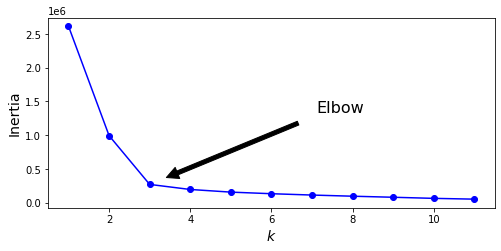

In [16]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 12), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

In [17]:
v1_model_8 = KMeans(n_clusters = 8)
v1_model_8.fit(pca)

KMeans()

In [19]:
# Silhouette Score
labels = v1_model_8.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.7978073053331654